In [23]:
import frites
import time
import tqdm
import cupy                               as cp
import cupyx                              as cpx
import numpy                              as np
import matplotlib.pyplot                  as plt 
import scipy                              as sp
from   cupyx.scipy.special import digamma as psi
from   frites.io           import set_log_level, logger

In [2]:
# Frites function
def mi_model_1d_gd(x, y, biascorrect=False, demeaned=False):
    """Mutual information between a Gaussian and a discrete variable in bits.
    This method is based on ANOVA style model comparison.
    I = mi_model_gd(x,y) returns the MI between the (possibly multidimensional)
    Gaussian variable x and the discrete variable y.
    Parameters
    ----------
    x, y : array_like
        Gaussian arrays of shape (n_epochs,) or (n_dimensions, n_epochs). y
        must be an array of integers
    biascorrect : bool | True
        Specifies whether bias correction should be applied to the estimated MI
    demeaned : bool | False
        Specifies whether the input data already has zero mean (true if it has
        been copula-normalized)
    Returns
    -------
    i : float
        Information shared by x and y (in bits)
    """
    x, y = np.atleast_2d(x), np.squeeze(y)
    if x.ndim > 2:
        raise ValueError("x must be at most 2d")
    if y.ndim > 1:
        raise ValueError("only univariate discrete variables supported")
    if not np.issubdtype(y.dtype, np.integer):
        raise ValueError("y should be an integer array")

    nvarx, ntrl = x.shape
    ym = np.unique(y)

    if y.size != ntrl:
        raise ValueError("number of trials do not match")

    if not demeaned:
        x = x - x.mean(axis=1)[:, np.newaxis]

    # class-conditional entropies
    ntrl_y = np.zeros(len(ym))
    hcond = np.zeros(len(ym))
    for n_yi, yi in enumerate(ym):
        idx = y == yi
        xm = x[:, idx]
        ntrl_y[n_yi] = xm.shape[1]
        xm = xm - xm.mean(axis=1)[:, np.newaxis]
        cm = np.dot(xm, xm.T) / float(ntrl_y[n_yi] - 1)
        chcm = np.linalg.cholesky(cm)
        hcond[n_yi] = np.sum(np.log(np.diagonal(chcm)))

    # class weights
    w = ntrl_y / float(ntrl)

    # unconditional entropy from unconditional Gaussian fit
    cx = np.dot(x, x.T) / float(ntrl - 1)
    chc = np.linalg.cholesky(cx)
    hunc = np.sum(np.log(np.diagonal(chc)))  # + c*nvarx

    ln2 = np.log(2)
    if biascorrect:
        vars = np.arange(1, nvarx + 1)

        psiterms = sp.special.psi((ntrl - vars).astype(np.float) / 2.) / 2.
        dterm = (ln2 - np.log(float(ntrl - 1))) / 2.
        hunc = hunc - nvarx * dterm - psiterms.sum()

        dterm = (ln2 - np.log((ntrl_y - 1).astype(np.float))) / 2.0
        psiterms = np.zeros(len(ym))
        for vi in vars:
            idx = ntrl_y - vi
            psiterms = psiterms + sp.special.psi(idx.astype(np.float) / 2.)
        hcond = hcond - nvarx * dterm - (psiterms / 2.)

    # MI in bits
    i = (hunc - np.sum(w * hcond)) / ln2
    return i

def mi_normal(rho):
    return -0.5 * np.log(1-rho**2) / np.log(2)

In [3]:
# Frites function
def mi_model_1d_gd_gpu(x, y, biascorrect=False, demeaned=False):
    """Mutual information between a Gaussian and a discrete variable in bits.
    This method is based on ANOVA style model comparison.
    I = mi_model_gd(x,y) returns the MI between the (possibly multidimensional)
    Gaussian variable x and the discrete variable y.
    Parameters
    ----------
    x, y : array_like
        Gaussian arrays of shape (n_epochs,) or (n_dimensions, n_epochs). y
        must be an array of integers
    biascorrect : bool | True
        Specifies whether bias correction should be applied to the estimated MI
    demeaned : bool | False
        Specifies whether the input data already has zero mean (true if it has
        been copula-normalized)
    Returns
    -------
    i : float
        Information shared by x and y (in bits)
    """
    # Converting to cupy array
    #x, y = cp.array(x), cp.array(y)
    x, y = cp.atleast_2d(x), cp.squeeze(y)
    if x.ndim > 2:
        raise ValueError("x must be at most 2d")
    if y.ndim > 1:
        raise ValueError("only univariate discrete variables supported")
    if not np.issubdtype(y.dtype, np.integer):
        raise ValueError("y should be an integer array")

    nvarx, ntrl = x.shape
    ym = cp.unique(y)

    if y.size != ntrl:
        raise ValueError("number of trials do not match")

    if not demeaned:
        x = x - x.mean(axis=1)[:, np.newaxis]

    # class-conditional entropies
    ntrl_y = cp.zeros(len(ym))
    hcond = cp.zeros(len(ym))
    for n_yi, yi in enumerate(ym):
        idx = y == yi
        xm = x[:, idx]
        ntrl_y[n_yi] = xm.shape[1]
        xm = xm - xm.mean(axis=1)[:, cp.newaxis]
        cm = cp.dot(xm, xm.T) / float(ntrl_y[n_yi] - 1)
        chcm = cp.linalg.cholesky(cm)
        hcond[n_yi] = cp.sum(cp.log(cp.diagonal(chcm)))

    # class weights
    w = ntrl_y / float(ntrl)

    # unconditional entropy from unconditional Gaussian fit
    cx = cp.dot(x, x.T) / float(ntrl - 1)
    chc = cp.linalg.cholesky(cx)
    hunc = cp.sum(cp.log(cp.diagonal(chc)))  # + c*nvarx

    ln2 = cp.log(2)
    if biascorrect:
        vars = cp.arange(1, nvarx + 1)

        psiterms = psi((ntrl - vars).astype(cp.float) / 2.) / 2.
        dterm = (ln2 - cp.log(float(ntrl - 1))) / 2.
        hunc = hunc - nvarx * dterm - psiterms.sum()

        dterm = (ln2 - cp.log((ntrl_y - 1).astype(cp.float))) / 2.0
        psiterms = cp.zeros(len(ym))
        for vi in vars:
            idx = ntrl_y - vi
            psiterms = psiterms + psi(idx.astype(cp.float) / 2.)
        hcond = hcond - nvarx * dterm - (psiterms / 2.)

    # MI in bits
    i = (hunc - cp.sum(w * hcond)) / ln2
    return i

In [4]:
# Generating coupled gaussian variables
def return_coupled_normal(Trials = 1, N = 1000, rho = 0.7):
    x = np.random.normal(0, rho, size=(Trials, N))
    y = np.random.randint(0, 10, size = N)
    return x,y

In [264]:
# Computing for different series length
N_arr = np.linspace(1000, 10000000, 30, dtype = int)
exta  = np.zeros([2, len(N_arr)])
exts  = np.zeros([2, len(N_arr)])

In [266]:
for i in range(N_arr.shape[-1]):
    x, y  = return_coupled_normal(Trials = 10, N = N_arr[i], rho = 0.7)
    # CPU
    aux = %timeit -o mi_model_1d_gd(x,y, biascorrect=True)
    exta[0,i] = aux.average
    exts[0,i] = aux.stdev
    # GPU 
    x_gpu, y_gpu = cp.array(x), cp.array(y)
    aux = %timeit -o mi_model_1d_gd_gpu(x_gpu,y_gpu, biascorrect=True)
    exta[1,i] = aux.average
    exts[1,i] = aux.stdev

1.21 ms ± 7.15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
8.69 ms ± 50 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
79.4 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.5 ms ± 51.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
171 ms ± 268 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
42.3 ms ± 39.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
256 ms ± 840 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
60.3 ms ± 97.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
343 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
78.3 ms ± 74.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
427 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
95.5 ms ± 518 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
517 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
114 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
604 ms ± 2.35 ms per loo

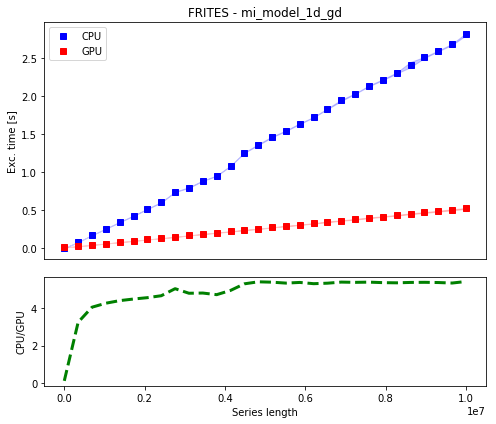

In [295]:
plt.figure(figsize=(7,6))
plt.subplot2grid((3,2), (0,0), rowspan = 2, colspan = 2)
plt.plot(N_arr, exta[0], 'sb', label = 'CPU')
plt.fill_between(N_arr, exta[0]-2*exts[0], exta[0]+2*exts[0], color = 'b', alpha = .2)
plt.plot(N_arr, exta[1], 'sr', label = 'GPU')
plt.fill_between(N_arr, exta[1]-2*exts[1], exta[1]+2*exts[1], color = 'r', alpha = .2)
plt.xticks([])
plt.title('FRITES - mi_model_1d_gd')
plt.ylabel('Exc. time [s]')
plt.legend()
plt.subplot2grid((3,2), (2,0), rowspan = 1, colspan = 2)
plt.plot(N_arr, exta[0]/exta[1], 'g--', lw = 3)
plt.ylabel(r'CPU/GPU')
plt.xlabel('Series length')
plt.tight_layout()
plt.savefig('mi_model_1d_gd.pdf', dpi = 600)

### Agnostic

In [41]:
def get_cupy(target='auto', verbose=None):
    """Get CuPy (if installed) otherwise get NumPy.
    Parameters
    ----------
    target : {'cpu', 'gpu', 'auto'}
        Specify if it's a CPU or GPU context. If auto, GPU is preferred but if
        it's failing, CPU is returned
    """
    set_log_level(verbose)
    assert target in ['cpu', 'gpu', 'auto']

    # ___________________________ Internal switches ___________________________

    def _get_np():
        import numpy as np
        cp = np
        cp.asnumpy = np.asarray
        return 'cpu', cp

    def _get_cp():
        import cupy as cp
        return 'gpu', cp

    # _____________________________ Global switch _____________________________
    if target == 'cpu':
        return _get_np()
    elif target == 'gpu':
        return _get_cp()
    elif target == 'auto':
        try:
            tgt, cp =  _get_cp()
            logger.info('Cupy imported')
        except:
            tgt, cp = _get_np()
            logger.error('Cannot import cupy. Using Numpy instead')
        return tgt, cp

def get_special(target='auto', verbose=None):
    """Get Cupyx special (if installed) otherwise get Scipy special.
    Parameters
    ----------
    target : {'cpu', 'gpu', 'auto'}
        Specify if it's a CPU or GPU context. If auto, GPU is preferred but if
        it's failing, CPU is returned
    """
    set_log_level(verbose)
    assert target in ['cpu', 'gpu', 'auto']

    # ___________________________ Internal switches ___________________________

    def _get_sp():
        import scipy.special as sp
        return 'cpu', sp

    def _get_cxsp():
        import cupyx.scipy.special as sp
        return 'gpu', sp

    # _____________________________ Global switch _____________________________
    if target == 'cpu':
        return _get_sp()
    elif target == 'gpu':
        return _get_cxsp()
    elif target == 'auto':
        try:
            tgt, sp =  _get_cxsp()
            logger.info('Cupy imported')
        except:
            tgt, sp = _get_sp()
            logger.error('Cannot import cupy. Using Scipy special instead')
        return tgt, sp

def get_cusignal(target='auto', verbose=False):
    """Get cusignal (if installed) otherwise get scipy.signal."""
    set_log_level(verbose)
    assert target in ['cpu', 'gpu', 'auto']

    # ___________________________ Internal switches ___________________________

    def _get_sp():
        from scipy import signal
        return 'cpu', signal

    def _get_cs():
        import cusignal
        return 'gpu', cusignal

    # _____________________________ Global switch _____________________________
    if target == 'cpu':
        return _get_sp()
    elif target == 'gpu':
        return _get_cs()
    elif target == 'auto':
        try:
            tgt, cs = _get_cs()
            logger.info('Cusignal imported')
        except:
            tgt, cs = _get_sp()
            logger.error('Cannot import cusignal. Using scipy.signal instead')
        return tgt, cs

In [42]:
# Frites function
def mi_model_1d_gd(x, y, biascorrect=False, target = 'auto', demeaned=False):
    """Mutual information between a Gaussian and a discrete variable in bits.
    This method is based on ANOVA style model comparison.
    I = mi_model_gd(x,y) returns the MI between the (possibly multidimensional)
    Gaussian variable x and the discrete variable y.
    Parameters
    ----------
    x, y : array_like
        Gaussian arrays of shape (n_epochs,) or (n_dimensions, n_epochs). y
        must be an array of integers
    biascorrect : bool | True
        Specifies whether bias correction should be applied to the estimated MI
    demeaned : bool | False
        Specifies whether the input data already has zero mean (true if it has
        been copula-normalized)
    Returns
    -------
    i : float
        Information shared by x and y (in bits)
    """
    # Converting to cupy array
    #x, y = cp.array(x), cp.array(y)
    # get librairies
    _, cp = get_cupy(target=target)
    _, sp = get_special(target=target)
    
    if target=='gpu' and isinstance(x, np.ndarray):
        x = cp.array(x)
    if target=='gpu' and isinstance(y, np.ndarray):
        y = cp.array(y)
        
    x, y = cp.atleast_2d(x), cp.squeeze(y)
    if x.ndim > 2:
        raise ValueError("x must be at most 2d")
    if y.ndim > 1:
        raise ValueError("only univariate discrete variables supported")
    if not np.issubdtype(y.dtype, np.integer):
        raise ValueError("y should be an integer array")

    nvarx, ntrl = x.shape
    ym = cp.unique(y)

    if y.size != ntrl:
        raise ValueError("number of trials do not match")

    if not demeaned:
        x = x - x.mean(axis=1)[:, np.newaxis]

    # class-conditional entropies
    ntrl_y = cp.zeros(len(ym))
    hcond = cp.zeros(len(ym))
    for n_yi, yi in enumerate(ym):
        idx = y == yi
        xm = x[:, idx]
        ntrl_y[n_yi] = xm.shape[1]
        xm = xm - xm.mean(axis=1)[:, cp.newaxis]
        cm = cp.dot(xm, xm.T) / float(ntrl_y[n_yi] - 1)
        chcm = cp.linalg.cholesky(cm)
        hcond[n_yi] = cp.sum(cp.log(cp.diagonal(chcm)))

    # class weights
    w = ntrl_y / float(ntrl)

    # unconditional entropy from unconditional Gaussian fit
    cx = cp.dot(x, x.T) / float(ntrl - 1)
    chc = cp.linalg.cholesky(cx)
    hunc = cp.sum(cp.log(cp.diagonal(chc)))  # + c*nvarx

    ln2 = cp.log(2)
    if biascorrect:
        vars = cp.arange(1, nvarx + 1)

        psiterms = sp.digamma((ntrl - vars).astype(cp.float) / 2.) / 2.
        dterm = (ln2 - cp.log(float(ntrl - 1))) / 2.
        hunc = hunc - nvarx * dterm - psiterms.sum()

        dterm = (ln2 - cp.log((ntrl_y - 1).astype(cp.float))) / 2.0
        psiterms = cp.zeros(len(ym))
        for vi in vars:
            idx = ntrl_y - vi
            psiterms = psiterms + sp.digamma(idx.astype(cp.float) / 2.)
        hcond = hcond - nvarx * dterm - (psiterms / 2.)

    # MI in bits
    i = (hunc - cp.sum(w * hcond)) / ln2
    return i

In [61]:
x, y  = return_coupled_normal(Trials = 10, N = 10000, rho = 0.7)
x_gpu, y_gpu = cp.array(x), cp.array(y)
print('cpu = ' + str(mi_model_1d_gd(x, y, target = 'cpu', biascorrect=True)))
print('gpu = ' + str(mi_model_1d_gd(x_gpu, y_gpu, target = 'gpu', biascorrect=True)))

cpu = 0.0016678385600327316
gpu = 0.0016678385600314503


In [62]:
# Computing for different series length
N_arr = np.linspace(1000, 10000000, 30, dtype = int)
exta  = np.zeros([2, len(N_arr)])
exts  = np.zeros([2, len(N_arr)])

In [63]:
for i in range(N_arr.shape[-1]):
    x, y  = return_coupled_normal(Trials = 10, N = N_arr[i], rho = 0.7)
    # CPU
    aux = %timeit -o mi_model_1d_gd(x, y, target = 'cpu', biascorrect=True)
    exta[0,i] = aux.average
    exts[0,i] = aux.stdev
    # GPU 
    x_gpu, y_gpu = cp.array(x), cp.array(y)
    aux = %timeit -o mi_model_1d_gd(x_gpu, y_gpu, target = 'gpu', biascorrect=True)
    exta[1,i] = aux.average
    exts[1,i] = aux.stdev

1.19 ms ± 2.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.09 ms ± 31.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
80.1 ms ± 474 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.9 ms ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
172 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
43.7 ms ± 59.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
257 ms ± 467 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
61.3 ms ± 29.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
344 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
79.2 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
429 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
96.3 ms ± 93.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
517 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
113 ms ± 690 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
608 ms ± 1.38 ms per lo

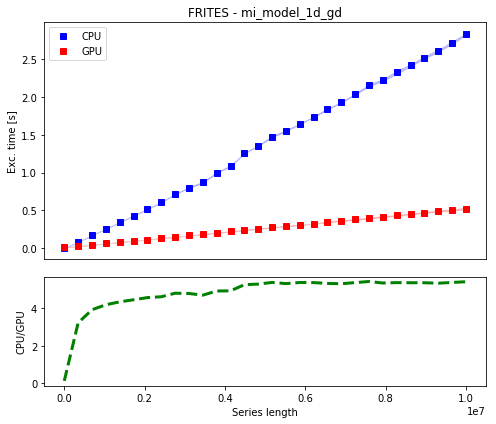

In [64]:
plt.figure(figsize=(7,6))
plt.subplot2grid((3,2), (0,0), rowspan = 2, colspan = 2)
plt.plot(N_arr, exta[0], 'sb', label = 'CPU')
plt.fill_between(N_arr, exta[0]-2*exts[0], exta[0]+2*exts[0], color = 'b', alpha = .2)
plt.plot(N_arr, exta[1], 'sr', label = 'GPU')
plt.fill_between(N_arr, exta[1]-2*exts[1], exta[1]+2*exts[1], color = 'r', alpha = .2)
plt.xticks([])
plt.title('FRITES - mi_model_1d_gd')
plt.ylabel('Exc. time [s]')
plt.legend()
plt.subplot2grid((3,2), (2,0), rowspan = 1, colspan = 2)
plt.plot(N_arr, exta[0]/exta[1], 'g--', lw = 3)
plt.ylabel(r'CPU/GPU')
plt.xlabel('Series length')
plt.tight_layout()
plt.savefig('mi_model_1d_gd.pdf', dpi = 600)